In [1]:
# to calculate the hausdroff distance of all the models

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [4]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [5]:
from model import Unet
from resunet import ResUnet
from transunet import TransUNet

In [6]:
from tqdm import tqdm

In [7]:
from PIL import Image

In [8]:
from monai import metrics

In [43]:
# data generator for Lung capacity dataset
class SegData(Dataset):

    def __init__(self,image_paths,mask_paths,img_mean,img_std,size = (256,256),transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std
        self.size = size
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index]).convert('RGB')
        mask = Image.open(self.mask_paths[index]).convert('L')

        image = np.array(image)
        mask = np.array(mask)

        image = np.transpose(image,(2,0,1))

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(image,0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = self.size),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = self.size,interpolation=transforms.InterpolationMode.NEAREST),
            transforms.Lambda(lambda x: x/torch.max(x)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        image = image.squeeze()
        mask = mask.squeeze()

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
        
        sample = {'image':image,'mask':mask}

        return sample

In [44]:
#creating input and output files for lung capacity segmentation
data_dir = '/Users/skapoor/Desktop/academics/academics_3/DL_MIS/assignment/assignment_2/COVID-19_Radiography_Dataset'
data_fold = [x.name for x in os.scandir(data_dir) if x.is_dir()]
data_fold.remove('.ipynb_checkpoints')

total_input_files_lung = []
total_output_files_lung = []
for fold in data_fold:
    fold_dir = os.path.join(data_dir,fold)
    for subfold in [x.name for x in os.scandir(os.path.join(data_dir,fold)) if (x.is_dir and x.name[0]!='.' and x.name!='Thumbs.db')]:
        subfold_dir = os.path.join(fold_dir,subfold)
        if subfold == 'images':
            total_input_files_lung.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])
        elif subfold == 'masks':
            total_output_files_lung.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])

In [45]:
#setting random state
seed = 13

In [46]:
_,valid_img,_,valid_mask = train_test_split(total_input_files_lung,total_output_files_lung,test_size=0.2,random_state=seed)
valid_data_unet = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
lung_data_unet = DataLoader(valid_data_unet,batch_size = 1,shuffle = False,pin_memory = True)
valid_data_transunet = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484],size = (128,128))
lung_data_transunet = DataLoader(valid_data_transunet,batch_size = 1,shuffle = False,pin_memory = True)


In [47]:
def convert_one_hot(img):
    img = torch.squeeze(img)
    uniq_values = torch.unique(img)
    value_indexes = {v.item():i for i,v in enumerate(uniq_values)}
    #print(value_indexes)
    one_hot = torch.zeros((1,len(uniq_values),img.shape[0],img.shape[1]))
    #print(one_hot.shape)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):

            pixel_val = img[y,x].item()
            #print(pixel_val)
            #print(value_indexes[pixel_val])
            one_hot[0,value_indexes[pixel_val],y,x] = torch.tensor(1)
    
    return one_hot


In [51]:
def hausdroff(model,model_wt,test_data_loader):

    model.load_state_dict(torch.load(model_wt,map_location = torch.device('cpu')))
    model.eval()

    hausdroff = metrics.compute_hausdorff_distance
    hausdroff_scores = []

    iou = metrics.compute_iou
    iou_scores = []

    dice = metrics.DiceMetric()
    dice_scores = []

    threshold = 0.5
    for k,batch in tqdm(enumerate(test_data_loader)):
        final_image = batch['image']
        final_mask = torch.unsqueeze(batch['mask'],1)
        #print(final_image.shape)
        #print(final_mask.shape)
        # break

        pred = model.forward(final_image)
        pred = torch.sigmoid(pred)
        pred_score = torch.where(pred>threshold,torch.tensor(1),torch.tensor(0))
        #print(pred_score.shape)
        #print(torch.unique(final_mask))
        one_hot_pred = convert_one_hot(pred_score)
        one_hot_mask = convert_one_hot(final_mask)
        #print(one_hot_pred.shape)
        #print(one_hot_mask.shape)

      
        hausdroff_score = hausdroff(one_hot_pred,one_hot_mask).item()
        hausdroff_scores.append(hausdroff_score)

        iou_score = iou(one_hot_pred,one_hot_mask)
        iou_score = torch.mean(iou_score).item()
        iou_scores.append(iou_score)

        dice_score = dice(one_hot_pred,one_hot_mask)
        dice_score = torch.mean(dice_score).item()
        dice_scores.append(dice_score)
        #print(iou_score)
        #print(dice_score)
        #break
        if(k>1000):
            break
    print('the average hasudroff_score is {0:.4f}'.format(np.mean(np.array(hausdroff_scores))))
    print('the average iou_score is {0:.4f}'.format(np.mean(np.array(iou_scores))))
    print('the average dice_score is {0:.4f}'.format(np.mean(np.array(dice_scores))))

    final_image_show = torch.squeeze(final_image).cpu().detach().numpy()
    final_image_transpose = np.transpose(final_image_show,(1,2,0))

    final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

    pred_image_transpose = torch.squeeze(pred).cpu().detach().numpy()

    bin_image_transpose = torch.squeeze(pred_score).cpu().detach().numpy()


    plt.figure(figsize = (8,8))
    plt.subplot(2,2,1)
    plt.imshow(final_image_transpose)
    plt.title('orignal image')

    plt.subplot(2,2,2)
    plt.imshow(final_mask_transpose,cmap = 'gray')
    plt.title('orignal mask')

    plt.subplot(2,2,3)
    plt.imshow(pred_image_transpose,cmap = 'jet',vmin = 0, vmax = 1)
    plt.title('pred map')

    plt.subplot(2,2,4)
    plt.imshow(bin_image_transpose,cmap = 'gray')
    plt.title('binary output')

for the q1 with unet model trained on BCE loss with best result


1001it [26:28,  1.59s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the average hasudroff_score is 3.7883
the average iou_score is 0.9852
the average dice_score is 0.9924


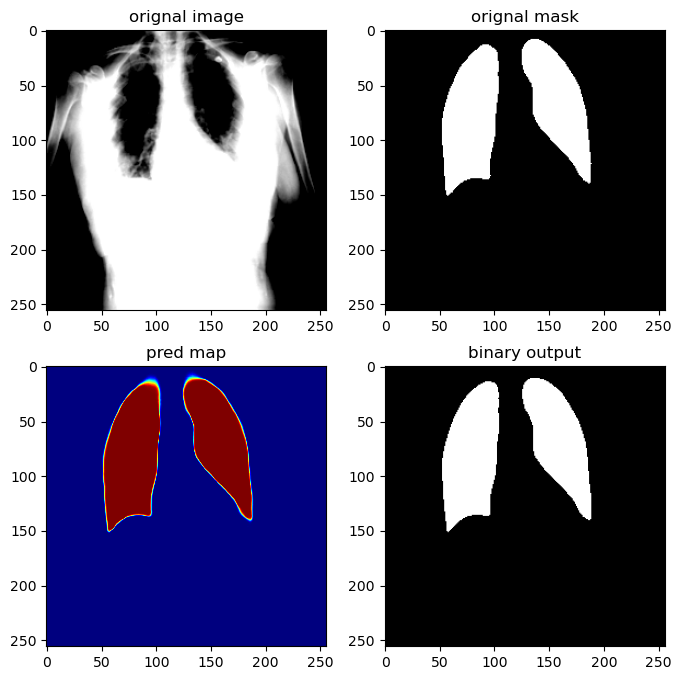

In [52]:
# for q1 trained on binary cross entropy loss
model = Unet(3,1)
model_wt = 'model_1_best_epoch9'
print('for the q1 with unet model trained on BCE loss with best result')
hausdroff(model=model,model_wt=model_wt,test_data_loader=lung_data_unet)


for q2 transunet trained on BCE with best result


1001it [06:16,  2.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the average hasudroff_score is 6.7843
the average iou_score is 0.9530
the average dice_score is 0.9751


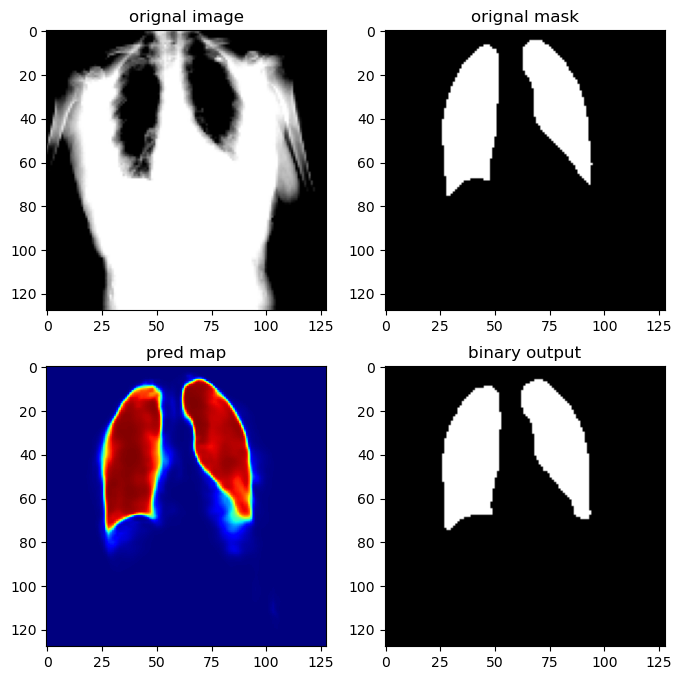

In [53]:
# for q2 lung dataset transunet trained on BCE loss
model = TransUNet(img_dim=128,
                          in_channels=3,
                          out_channels=128,
                          head_num=4,
                          mlp_dim=512,
                          block_num=8,
                          patch_dim=16,
                          class_num=1)
model_wt = 'model_q2_transunet_best_epoch8'
print('for q2 transunet trained on BCE with best result')
hausdroff(model=model,model_wt=model_wt,test_data_loader=lung_data_transunet)

In [62]:
class SegDataNp(Dataset):

    def __init__(self,image_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):

        file =  np.load(self.image_paths[index])

        image = file[0]
        mask = file[1]

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(torch.unsqueeze(image,dim=0),dim=0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128),interpolation=transforms.InterpolationMode.NEAREST),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
            
        image = image.squeeze()
        mask = mask.squeeze()
        
        sample = {'image':image,'mask':mask}

        return sample

In [76]:
def convert_one_hot_np(img,num_class = 4):
    img = torch.squeeze(img)
    # uniq_values = torch.unique(img)
    # value_indexes = {v.item():i for i,v in enumerate(uniq_values)}
    # #print(value_indexes)
    one_hot = torch.zeros((1,num_class,img.shape[0],img.shape[1]))
    #print(one_hot.shape)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):

            pixel_val = img[y,x].item()
            #print(pixel_val)
            #print(value_indexes[pixel_val])
            one_hot[0,pixel_val,y,x] = torch.tensor(1)
    
    return one_hot

In [64]:
test_dir = '/Users/skapoor/Desktop/academics/academics_3/DL_MIS/assignment/assingment_3/ACDC/database/test_files'
test_heart_files = []
for file in os.listdir(test_dir):
    if file.endswith('.npy'):
        test_heart_files.append(os.path.join(test_dir,file))
test_heart_data = SegDataNp(image_paths=test_heart_files,img_mean=90,img_std=101)
test_heart_loader = DataLoader(test_heart_data,batch_size=1,shuffle=True,pin_memory=True)

In [94]:
def hausdroff_np(model,model_wt,test_data_loader):

    model.load_state_dict(torch.load(model_wt,map_location = torch.device('cpu')))
    model.eval()

    hausdroff = metrics.compute_hausdorff_distance
    hausdroff_scores = []

    iou = metrics.compute_iou
    iou_scores = []

    dice = metrics.DiceMetric()
    dice_scores = []

    threshold = 0.5
    for k,batch in tqdm(enumerate(test_data_loader)):
        final_image = torch.unsqueeze(batch['image'],1)
        final_mask = batch['mask']
        # print(final_image.shape)
        # print(final_mask.shape)
        # break

        pred = model.forward(final_image)
        pred = torch.nn.Softmax(dim=1)(pred)
        _,y_pred_idx = torch.max(pred,dim=1)
        #print(y_pred_idx.shape)
        #print(final_mask.shape)

        

        one_hot_pred = convert_one_hot_np(y_pred_idx)
        one_hot_mask = convert_one_hot_np(final_mask)
        #print(one_hot_pred.shape)
        #print(one_hot_mask.shape)

        #break
      
        hausdroff_score = hausdroff(one_hot_pred,one_hot_mask)
        hausdroff_score = torch.mean(hausdroff_score).item()
        if math.isnan(hausdroff_score) == False and math.isinf(hausdroff_score) == False:
            hausdroff_scores.append(hausdroff_score)

        iou_score = iou(one_hot_pred,one_hot_mask)
        iou_score = torch.mean(iou_score).item()
        if math.isnan(iou_score) == False:
            iou_scores.append(iou_score)

        dice_score = dice(one_hot_pred,one_hot_mask)
        dice_score = torch.mean(dice_score).item()
        if math.isnan(dice_score) == False:
            dice_scores.append(dice_score)
        #print(iou_score)
        #print(dice_score)
        #break
        if(k>1000):
            break
    #return
    #print(hausdroff_scores)
    print('the average hasudroff_score is {0:.4f}'.format(np.mean(np.array(hausdroff_scores))))
    print('the average iou_score is {0:.4f}'.format(np.mean(np.array(iou_scores))))
    print('the average dice_score is {0:.4f}'.format(np.mean(np.array(dice_scores))))

    final_image_transpose = torch.squeeze(final_image).cpu().detach().numpy()
                                    
    final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

    pred_image_transpose = torch.squeeze(y_pred_idx).cpu().detach().numpy()

    plt.figure(figsize = (12,4))
    plt.subplot(1,3,1)
    plt.imshow(final_image_transpose)
    plt.title('orignal image')

    plt.subplot(1,3,2)
    plt.imshow(final_mask_transpose)
    plt.title('orignal mask')

    plt.subplot(1,3,3)
    plt.imshow(pred_image_transpose)
    plt.title('pred mask')

for the q3 with unet model trained on BCE loss with best result


9it [00:03,  2.53it/s]/opt/homebrew/Caskroom/miniforge/base/envs/sk_pytorch_env/lib/python3.8/site-packages/monai/metrics/utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
69it [00:27,  2.57it/s]/opt/homebrew/Caskroom/miniforge/base/envs/sk_pytorch_env/lib/python3.8/site-packages/monai/metrics/utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sk_pytorch_env/lib/python3.8/site-packages/monai/metrics/utils.py:333: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sk_pytorch_env/lib/python3.8/site-packages/monai/metrics/utils.py:333: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sk_pytorch_env/lib/python3.8/site-pack

[8.122903823852539, 6.440282821655273, 10.144242286682129, 10.162728309631348, 8.52238655090332, 9.342236518859863, 5.7333526611328125, 7.206948757171631, 4.422911167144775, 27.867307662963867, 10.63088321685791, 8.544049263000488, 20.03354835510254, 11.091521263122559, 7.682506561279297, 20.156644821166992, 8.396368980407715, 7.81266975402832, 13.497693061828613, 5.4273505210876465, 9.666666984558105, 8.921935081481934, 7.740955352783203, 9.148826599121094, 5.677765369415283, 51.825653076171875, 9.998193740844727, 20.71503257751465, 35.30863571166992, 6.9709858894348145, 27.106895446777344, 10.693890571594238, 8.558581352233887, 6.601497650146484, 7.984957218170166, 9.115078926086426, 8.283713340759277, 8.00757122039795, 9.692412376403809, 13.153536796569824, 8.476916313171387, 8.832533836364746, 9.195754051208496, 7.416095733642578, 7.309291839599609, 8.811980247497559, 16.123292922973633, 6.2152533531188965, 8.616718292236328, 6.070167064666748, 10.277605056762695, 9.494091987609863

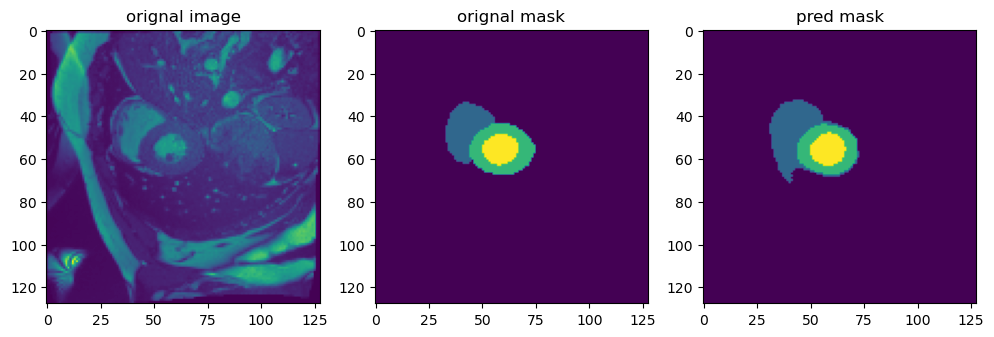

In [92]:
model = Unet(1,4)
model_wt = 'model_q3_unet_best_epoch19'
print('for the q3 with unet model trained on BCE loss with best result')
hausdroff_np(model=model,model_wt=model_wt,test_data_loader=test_heart_loader)

for the q3 with resunet model trained on BCE loss with best result


0it [00:00, ?it/s]

1001it [07:29,  2.23it/s]


the average hasudroff_score is 12.7580
the average iou_score is 0.7534
the average dice_score is 0.8364


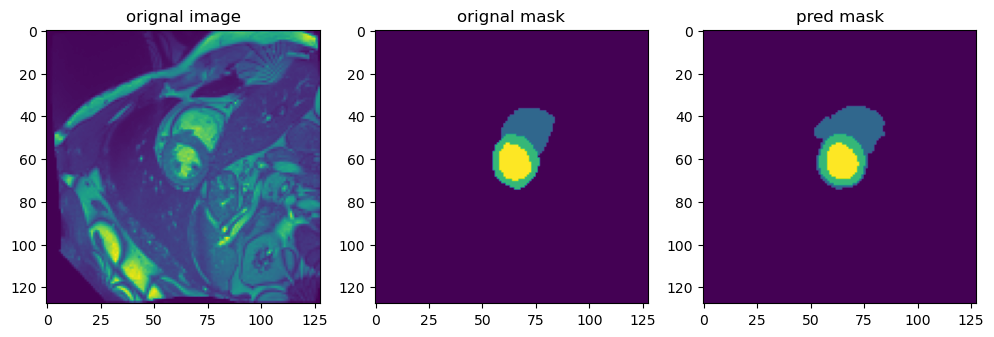

In [95]:
model = ResUnet(in_channel=1,out_channel=4)
model_wt = 'model_q3_resunet_best_epoch27'
print('for the q3 with resunet model trained on BCE loss with best result')
hausdroff_np(model=model,model_wt=model_wt,test_data_loader=test_heart_loader)

for the q3 with resunet model trained on BCE loss with best result


1001it [06:01,  2.77it/s]


the average hasudroff_score is 13.0043
the average iou_score is 0.6696
the average dice_score is 0.7636


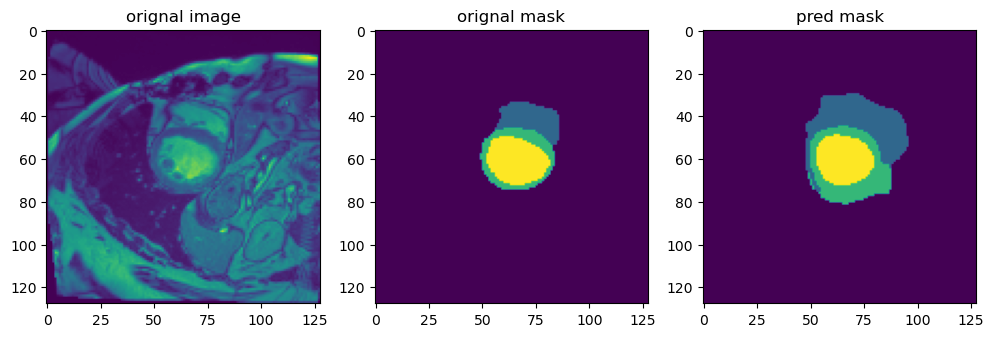

In [96]:
model = TransUNet(img_dim=128,
                    in_channels=1,
                    out_channels=128,
                    head_num=4,
                    mlp_dim=512,
                    block_num=8,
                    patch_dim=16,
                    class_num=4)
model_wt = 'model_q3_transunet_best_epoch84'
print('for the q3 with resunet model trained on BCE loss with best result')
hausdroff_np(model=model,model_wt=model_wt,test_data_loader=test_heart_loader)